In [7]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
%matplotlib inline
'''
在下载数据集之前，要设定转换参数：transform，该参数里解决两个问题：
- ToTensor：将图像数据转为张量，且调整三个维度的顺序为C*W*H；C表示通道数，二维灰度图像的通道数为1，三维RGB 彩图的通道数为3。
- Normalize：将神经网络的输入数据转化为标准正态分布，训练更好；根据统计计算，MNIST 训练集所有像素的均值是0.1307、标准差是0.3081。
'''

'\n在下载数据集之前，要设定转换参数：transform，该参数里解决两个问题：\n- ToTensor：将图像数据转为张量，且调整三个维度的顺序为C*W*H；C表示通道数，二维灰度图像的通道数为1，三维RGB 彩图的通道数为3。\n- Normalize：将神经网络的输入数据转化为标准正态分布，训练更好；根据统计计算，MNIST 训练集所有像素的均值是0.1307、标准差是0.3081。\n'

In [11]:
# 制作数据集
# 数据集转换参数
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.1307, 0.3081)
])

# 下载训练集与测试集
train_Data = datasets.MNIST(
    root = 'F:\Jupyter\pytorch\dataset\mnist', # 下载路径
    train = True, # 是train 集
    download = True, # 如果该路径没有该数据集，就下载
    transform = transform # 数据集转换参数
)

test_Data = datasets.MNIST(
    root = 'F:\Jupyter\pytorch\dataset\mnist', # 下载路径
    train = False, # 是test 集
    download = True, # 如果该路径没有该数据集，就下载
    transform = transform # 数据集转换参数
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting F:\Jupyter\pytorch\dataset\mnist\MNIST\raw\train-images-idx3-ubyte.gz to F:\Jupyter\pytorch\dataset\mnist\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting F:\Jupyter\pytorch\dataset\mnist\MNIST\raw\train-labels-idx1-ubyte.gz to F:\Jupyter\pytorch\dataset\mnist\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting F:\Jupyter\pytorch\dataset\mnist\MNIST\raw\t10k-images-idx3-ubyte.gz to F:\Jupyter\pytorch\dataset\mnist\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%

Extracting F:\Jupyter\pytorch\dataset\mnist\MNIST\raw\t10k-labels-idx1-ubyte.gz to F:\Jupyter\pytorch\dataset\mnist\MNIST\raw



In [12]:
# 批次加载器
train_loader = DataLoader(train_Data, shuffle=True, batch_size=64)
test_loader = DataLoader(test_Data, shuffle=False, batch_size=64)

In [13]:
'''
每个样本的输入都是形状为2828的二维数组，那么对于 DNN 来说，输入层的神经元节点就要有28x28 = 784个；输出层使用独热编码，需要 10 个节点。
'''
class DNN(nn.Module):
    def __init__(self):
        ''' 搭建神经网络各层 '''
        super(DNN,self).__init__()
        self.net = nn.Sequential( # 按顺序搭建各层
        nn.Flatten(), # 把图像铺平成一维
        nn.Linear(784, 512), nn.ReLU(), # 第1 层：全连接层
        nn.Linear(512, 256), nn.ReLU(), # 第2 层：全连接层
        nn.Linear(256, 128), nn.ReLU(), # 第3 层：全连接层
        nn.Linear(128, 64), nn.ReLU(), # 第4 层：全连接层
        nn.Linear(64, 10) # 第5 层：全连接层
    )
    def forward(self, x):
        ''' 前向传播 '''
        y = self.net(x) # x 即输入数据
        return y # y 即输出数据

In [14]:
model = DNN().to('cuda:0') # 创建子类的实例，并搬到GPU 上
model # 查看该实例的各层

DNN(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=128, bias=True)
    (6): ReLU()
    (7): Linear(in_features=128, out_features=64, bias=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [15]:
# 损失函数的选择
loss_fn = nn.CrossEntropyLoss() # 自带softmax 激活函数

In [16]:
# 优化算法的选择
learning_rate = 0.01 # 设置学习率
optimizer = torch.optim.SGD(
    model.parameters(),
    lr = learning_rate,
    momentum = 0.5
)

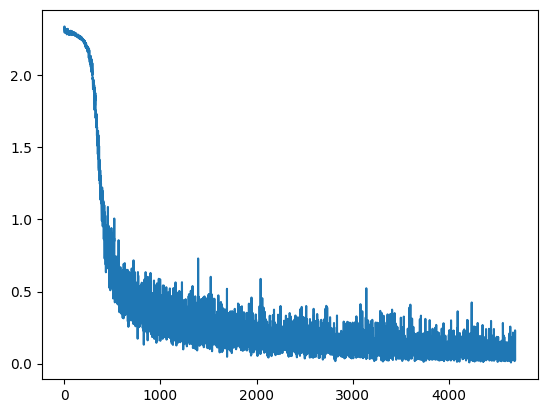

In [17]:
# 训练网络
epochs = 5
losses = [] # 记录损失函数变化的列表
for epoch in range(epochs):
    for (x, y) in train_loader: # 获取小批次的x 与y
        x, y = x.to('cuda:0'), y.to('cuda:0')
        Pred = model(x) # 一次前向传播（小批量）
        loss = loss_fn(Pred, y) # 计算损失函数
        losses.append(loss.item()) # 记录损失函数的变化
        optimizer.zero_grad() # 清理上一轮滞留的梯度
        loss.backward() # 一次反向传播
        optimizer.step() # 优化内部参数
Fig = plt.figure()
plt.plot(range(len(losses)), losses)
plt.show()

In [21]:
# 测试网络
correct = 0
total = 0
with torch.no_grad(): # 该局部关闭梯度计算功能
    for (x, y) in test_loader: # 获取小批次的x 与y
        x, y = x.to('cuda:0'), y.to('cuda:0')
        Pred = model(x) # 一次前向传播（小批量）
        _, predicted = torch.max(Pred.data, dim=1)
        print(f"predicted={predicted}")
        correct += torch.sum( (predicted == y) )
        total += y.size(0)
print(f'测试集精准度: {100*correct/total} %')

predicted=tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3], device='cuda:0')
predicted=tensor([7, 4, 6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3,
        6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7,
        3, 9, 7, 4, 4, 4, 9, 2, 5, 4, 7, 6, 7, 9, 0, 5], device='cuda:0')
predicted=tensor([8, 5, 6, 6, 5, 7, 8, 1, 0, 1, 6, 4, 6, 7, 3, 1, 7, 1, 8, 2, 0, 2, 9, 9,
        5, 5, 1, 5, 6, 0, 3, 4, 4, 6, 5, 4, 6, 5, 4, 5, 1, 4, 4, 7, 2, 3, 2, 7,
        1, 8, 1, 8, 1, 8, 5, 0, 8, 9, 2, 5, 0, 1, 1, 1], device='cuda:0')
predicted=tensor([0, 9, 0, 3, 1, 6, 4, 2, 3, 6, 1, 1, 1, 3, 9, 5, 2, 9, 4, 5, 9, 3, 9, 0,
        3, 6, 5, 5, 7, 2, 2, 7, 1, 2, 8, 4, 1, 7, 3, 3, 8, 7, 7, 9, 2, 2, 4, 1,
        5, 9, 8, 7, 2, 3, 0, 2, 4, 2, 4, 1, 9, 5, 7, 7], device='cuda:0')
predicted=tensor([2, 8, 